In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class CustomKMeans:
    def __init__(self, n_clusters, max_iter=10, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def fit(self, X):
        np.random.seed(self.random_state)
        # Initialize centroids using kmeans++
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iter):
            # Assign each data point to the nearest centroid
            labels = self._assign_labels(X)
            # Update centroids based on the mean of data points in each cluster
            new_centroids = self._update_centroids(X, labels)
            # Check if centroids have converged
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break
            self.centroids = new_centroids
            self.labels = labels

    def predict(self, X):
        # Assign each data point to the nearest centroid
        return self._assign_labels(X)

    def inertia(self, X):
        # Calculate inertia (sum of squared distances of samples to their closest cluster center)
        labels = self.predict(X)
        distances = np.array([np.linalg.norm(X[i] - self.centroids[labels[i]]) ** 2 for i in range(len(X))])
        return np.sum(distances)

    def _initialize_centroids(self, X):
        centroids = [X[np.random.choice(X.shape[0])]]
        while len(centroids) < self.n_clusters:
            dist_sq = np.array([min([np.linalg.norm(x - c)**2 for c in centroids]) for x in X])
            probs = dist_sq / dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = np.random.rand()
            i = np.searchsorted(cumulative_probs, r)
            centroids.append(X[i])
        return np.array(centroids)

    def _assign_labels(self, X):
        # Assign each data point to the nearest centroid
        return np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2), axis=1)

    def _update_centroids(self, X, labels):
        # Update centroids based on the mean of data points in each cluster
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.sum(labels == i) > 0 else self.centroids[i] for i in range(self.n_clusters)])
        return new_centroids


In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
# Load data
print("Loading data...")
movie_data = pd.read_csv('/content/drive/MyDrive/rsdats/movies.csv')
user_data = pd.read_csv('/content/drive/MyDrive/rsdats/users.csv')
rating_data = pd.read_csv('/content/drive/MyDrive/rsdats/ratings.csv')

# Merge rating data with movie data
print("Merging rating data with movie data...")
merged_data = pd.merge(rating_data, movie_data, left_on='MovieID', right_on='ID')

# Merge with user data using UserID
print("Merging with user data using UserID...")
merged_data = pd.merge(merged_data, user_data, on='UserID')

# Pivot table of user ratings with movie titles as columns
print("Creating user-item matrix...")
user_ratings = merged_data.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)

# Split data into train and test sets
print("Splitting data into train and test sets...")
train_data, test_data = train_test_split(user_ratings.values, test_size=0.2, random_state=42)


Loading data...
Merging rating data with movie data...
Merging with user data using UserID...
Creating user-item matrix...
Splitting data into train and test sets...


In [ ]:
import numpy as np
from tqdm import tqdm

class CustomSVD:
    def __init__(self, A, num_components=None):
        print("Computing SVD...")
        self.U, self.S, self.Vt = self.svd(A, num_components)

    def svd(self, A, num_components=None):
        m, n = A.shape

        # Compute A^T * A
        print("Compute A^T * A")
        ATA = A.T.dot(A)

        # Compute eigenvalues and eigenvectors of A^T * A
        print("Compute eigenvalues and eigenvectors of A^T * A")
        eigenvalues, Vt = self.power_iteration(ATA)

        # Sort eigenvalues in descending order
        print("Sort eigenvalues in descending order")
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        Vt = Vt[:, idx]

        # Determine the number of components
        if num_components is None:
            num_components = min(m, n)

        # Truncate singular values and vectors
        singular_values = np.sqrt(eigenvalues)[:num_components]
        U = np.zeros((m, num_components))
        for i in tqdm(range(num_components), desc="Computing U"):
            u = np.dot(A, Vt[:, i]) / singular_values[i]
            for j in range(i):
                u -= np.dot(U[:, j], u) * U[:, j]
            U[:, i] = u / np.linalg.norm(u)

        return U, np.diag(singular_values), Vt.T[:, :num_components]

    def power_iteration(self, A, max_iter=50, tol=1e-6):
        n = A.shape[0]
        eigenvalues = np.zeros(n)
        eigenvectors = np.zeros((n, n))

        for i in tqdm(range(n), desc="power itr"):
            # Set an initial guess for the eigenvector
            x = np.random.rand(n)
            x /= np.linalg.norm(x)

            # Iterative method to find eigenvalues and eigenvectors using Power Iteration
            for _ in range(max_iter):
                x_next = A.dot(x)
                eigenvalue = np.linalg.norm(x_next)
                x_next /= eigenvalue

                # Check for convergence
                if np.linalg.norm(x_next - x) < tol:
                    break

                x = x_next

            # Set the computed eigenvalue and eigenvector
            eigenvalues[i] = eigenvalue
            eigenvectors[:, i] = x

            # Deflate the matrix
            A -= eigenvalue * np.outer(x, x)

        return eigenvalues, eigenvectors


In [ ]:
# Apply SVD to reduce dimensions of the train data
svd = CustomSVD(train_data)
U_train, S_train, Vt_train = svd.U, svd.S, svd.Vt

Computing SVD...
Compute A^T * A
Compute eigenvalues and eigenvectors of A^T * A


power itr: 100%|██████████| 3706/3706 [44:39<00:00,  1.38it/s]


Sort eigenvalues in descending order


Computing U: 100%|██████████| 3706/3706 [31:58<00:00,  1.93it/s]


In [ ]:
import pickle

# Save clusters dictionary
with open('/content/drive/MyDrive/Reduced SVD then KMeans/u1n1.pkl', 'wb') as f:
    pickle.dump(U_train, f)

# Save kmeans object
with open('/content/drive/MyDrive/Reduced SVD then KMeans/s1n1.pkl', 'wb') as f:
    pickle.dump(S_train, f)

# Save kmeans object
with open('/content/drive/MyDrive/Reduced SVD then KMeans/vt1n1.pkl', 'wb') as f:
    pickle.dump(Vt_train, f)


In [ ]:
import pickle
# Load clusters dictionary
with open('/content/u1n1.pkl', 'rb') as f:
    U_train = pickle.load(f)

# Load kmeans object
with open('/content/s1n1.pkl', 'rb') as f:
    S_train = pickle.load(f)

# Load kmeans object
with open('/content/vt1n1.pkl', 'rb') as f:
    Vt_train = pickle.load(f)


In [ ]:
U_train , S_train , Vt_train

(array([[ 0.00726739, -0.00827085, -0.02490433, ...,  0.02539926,
         -0.00496145,  0.02120697],
        [ 0.00492903,  0.01049248,  0.0080882 , ...,  0.00061303,
          0.01652549, -0.0141496 ],
        [ 0.00090098, -0.00033175, -0.00135142, ..., -0.01132548,
         -0.01821929,  0.00143933],
        ...,
        [ 0.00703618, -0.0249619 , -0.00898346, ..., -0.00979362,
         -0.00036487,  0.01415439],
        [ 0.00129769,  0.00119158, -0.00115454, ...,  0.0118379 ,
         -0.01733815, -0.00722914],
        [ 0.00668621, -0.00315104,  0.00191139, ..., -0.03037682,
          0.02306527,  0.02505082]]),
 array([[1.70876963e+03, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.05628375e+02, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.13990319e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,


26101418222630

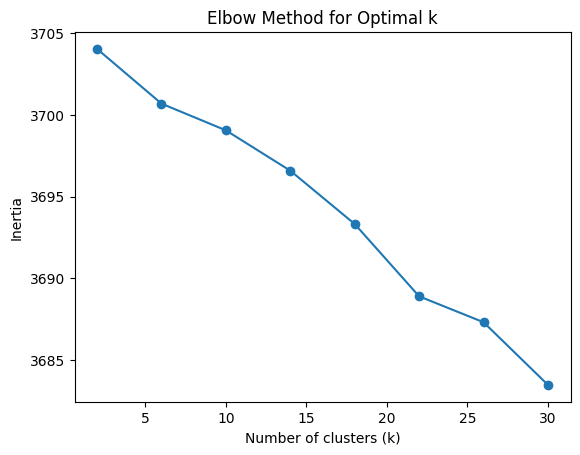

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate inertia for different values of k
def calculate_inertia(X, k):
    print(k,end="")
    kmeans = CustomKMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia(X)

# Define the range of clusters to test
k_values = range(2, 31,4)
inertia_values = [calculate_inertia(U_train, k) for k in k_values]

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [ ]:
k_values,inertia_values

(range(2, 31, 4),
 [3704.041360781447,
  3700.6918972918193,
  3699.0566132168497,
  3696.5853309751237,
  3693.3205488200765,
  3688.8945144614217,
  3687.3093212364493,
  3683.471649646145])

In [ ]:
# Split data into training and testing subsets
from sklearn.metrics import silhouette_score

# Apply KMeans clustering to cluster users based on reduced features
kmeans = CustomKMeans(n_clusters=22)
kmeans.fit(U_train)


In [ ]:
import pickle

# Save clusters dictionary
with open('/content/drive/MyDrive/Reduced SVD then KMeans/kmeans1.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [ ]:
import pickle
# Load clusters dictionary
with open('/content/kmeans1.pkl', 'rb') as f:
    kmeans = pickle.load(f)

In [ ]:
# Add cluster labels to user data
cluster_labels_train = kmeans.predict(U_train)

In [ ]:
train_data_with_clusters = pd.DataFrame(data=U_train, columns=[f'Component_{i}' for i in range(U_train.shape[1])])
train_data_with_clusters['Cluster'] = cluster_labels_train

In [ ]:
import pickle

# Save clusters dictionary
with open('/content/drive/MyDrive/Reduced SVD then KMeans/train_data_with_clusters.pkl', 'wb') as f:
    pickle.dump(train_data_with_clusters, f)

In [ ]:
import pickle
# Load clusters dictionary
with open('/content/train_data_with_clusters.pkl', 'rb') as f:
    train_data_with_clusters = pickle.load(f)

In [ ]:
train_data_with_clusters

,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,...,Component_3697,Component_3698,Component_3699,Component_3700,Component_3701,Component_3702,Component_3703,Component_3704,Component_3705,Cluster
0,0.007267,-0.008271,-0.024904,-0.011874,-0.001376,0.013138,0.017991,-0.024831,-0.010667,0.030483,...,-0.000482,0.013519,-0.020105,0.008054,-0.016942,-0.013072,0.025399,-0.004961,0.021207,9
1,0.004929,0.010492,0.008088,0.001915,-0.010511,-0.008306,0.007712,-0.007161,0.010395,0.004409,...,0.007087,-0.004731,0.013353,0.013605,-0.006619,-0.005730,0.000613,0.016525,-0.014150,9
2,0.000901,-0.000332,-0.001351,0.001003,0.001809,-0.000788,-0.000512,0.002172,0.000575,0.004766,...,-0.012356,0.013358,-0.013530,-0.021923,-0.008022,-0.011469,-0.011325,-0.018219,0.001439,9
3,0.011301,-0.003215,-0.006178,-0.019811,-0.001421,-0.014980,0.005929,-0.012898,0.008198,-0.007299,...,-0.000314,0.005009,-0.016750,-0.006296,0.033984,-0.000136,0.009445,-0.004346,-0.016421,9
4,0.004684,-0.002457,-0.008922,-0.003986,-0.010062,-0.001367,-0.003824,-0.006877,-0.001242,-0.000207,...,0.009175,-0.014181,0.004404,0.006629,0.008581,-0.007048,0.029367,-0.006626,0.007470,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,0.023213,-0.002065,0.005780,0.013536,-0.028320,0.014921,-0.043288,0.017790,0.010468,0.009751,...,0.000642,-0.008348,0.030842,0.023799,0.009595,-0.007982,-0.000822,0.006646,-0.017947,9
4828,0.001608,-0.000418,0.000880,-0.002702,-0.003029,-0.000164,0.004746,0.003012,0.004114,0.008152,...,-0.010886,-0.007967,0.016247,0.012458,-0.006138,0.010817,0.005411,0.004021,0.004377,9
4829,0.007036,-0.024962,-0.008983,-0.002890,0.014993,-0.007300,0.006821,-0.005717,0.021787,-0.007139,...,-0.003645,-0.002030,-0.002256,-0.012294,0.007137,-0.000961,-0.009794,-0.000365,0.014154,9
4830,0.001298,0.001192,-0.001155,-0.000157,0.001629,-0.001541,0.000146,0.001780,-0.000230,0.003249,...,0.000555,-0.010539,-0.009961,-0.017523,0.015562,-0.023846,0.011838,-0.017338,-0.007229,9


In [60]:
from tqdm import tqdm

# Function to evaluate recommendations for each row in the test data
def evaluate_recommendations(test_data, train_data_with_clusters, merged_data, Vt_transposed, kmeans):
    total_rows = len(test_data)
    total_correct_predictions = 0

    for index, row in tqdm(enumerate(test_data), total=total_rows, desc="Evaluating Recommendations"):
        # Transform the row using Vt_transposed
        row_transformed = np.dot(row, Vt_transposed)

        # Predict the cluster using KMeans
        new_user_cluster = kmeans.predict(row_transformed.reshape(1, -1))[0]

        # Filter users in the same cluster
        users_same_cluster = train_data_with_clusters[train_data_with_clusters['Cluster'] == new_user_cluster]

        # Get the indices of users in the same cluster
        user_indices_same_cluster = users_same_cluster.index

        # Filter ratings of users in the same cluster
        ratings_same_cluster = merged_data[merged_data['UserID'].isin(user_indices_same_cluster)]

        # Calculate the mean rating for each movie among users in the same cluster
        mean_ratings = ratings_same_cluster.groupby('Title')['Rating'].mean()

        # Get the actual ratings for the movies in the current row
        actual_ratings = row

        # Initialize a counter for matching predictions
        matching_predictions = 0

        # Check if the ratings of recommended movies match with the actual ratings
        for movie, mean_rating in mean_ratings.items():
            if movie in user_ratings.columns:
                # Get the index of the movie in the test data row
                movie_index = np.where(user_ratings.columns == movie)[0][0]

                # Get the actual rating of the movie in the test data row
                actual_rating = actual_ratings[movie_index]

                # Compare the recommended rating with the actual rating
                if mean_rating == actual_rating:
                    matching_predictions += 1

        # Increment the total number of correct predictions
        total_correct_predictions += matching_predictions

    # Calculate accuracy
    accuracy = total_correct_predictions / (total_rows * 5)

    return accuracy

# Evaluate recommendations for test data
accuracy = evaluate_recommendations(test_data, train_data_with_clusters, merged_data, Vt_train.T, kmeans)
print(f"Accuracy of recommendations for test data: {accuracy}")


Evaluating Recommendations: 100%|██████████| 1208/1208 [03:35<00:00,  5.60it/s]

Accuracy of recommendations for test data: 0.8372516556291391


In [62]:
accuracy

0.8372516556291391

# New User

In [ ]:
# New user ratings
new_user_ratings = {'Toy Story (1995)': 5, 'Jurassic Park (1993)': 4, 'Forrest Gump (1994)': 3}

# Create a DataFrame for the new user
new_user_data = pd.DataFrame(new_user_ratings, index=[0])

# Convert movie titles to columns
new_user_movies = pd.DataFrame(columns=user_ratings.columns)

# Merge new user data with the movie DataFrame
new_user_data_merged = pd.merge(new_user_movies, new_user_data, how='outer').fillna(0)

# Reorder the columns of new_user_data_merged to match the order of user_ratings
new_user_data_reordered = new_user_data_merged[user_ratings.columns]

In [ ]:
new_user_data_reordered

,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Transform the new user data using SVD
new_user_data_reduced = np.dot(new_user_data_reordered, Vt_train.T)

# Find the cluster of the new user
new_user_cluster = kmeans.predict(new_user_data_reduced)
print(new_user_cluster)

[17]


In [ ]:
# Filter users in the same cluster
users_same_cluster = train_data_with_clusters[train_data_with_clusters['Cluster'] == new_user_cluster[0]]

# Get the indices of users in the same cluster
user_indices_same_cluster = users_same_cluster.index

# Filter ratings of users in the same cluster
ratings_same_cluster = merged_data[merged_data['UserID'].isin(user_indices_same_cluster)]

# Calculate the mean rating for each movie among users in the same cluster
mean_ratings = ratings_same_cluster.groupby('Title')['Rating'].mean().sort_values(ascending=False)

print(mean_ratings.head())


Title
Friday the 13th Part VII: The New Blood (1988)    5.0
Sanjuro (1962)                                    5.0
Homegrown (1998)                                  5.0
Buddy (1997)                                      5.0
Last Supper, The (1995)                           5.0
Name: Rating, dtype: float64
